# 1. Introduction of ADMM pruning

## 1.1 Introduction to ADMM
The Alternating Direction Method of Multipliers (ADMM) is a strong optimization technique. It's especially useful for problems that can be broken down into simpler sub-problems. This method is perfect for dealing with nonconvex optimization problems with combinatorial constraints, like weight pruning in Deep Neural Networks (DNNs).

ADMM is based on the method of multipliers, a way to solve constrained optimization problems. It uses the concept of the Lagrange multiplier, a strategy to find the highest and lowest points of a function under equality constraints. The Lagrange multiplier method introduces a new variable (the multiplier) for each constraint. It forms a Lagrangian function by adding the product of the multipliers and the constraints to the objective function. By finding the stable points of this Lagrangian function, we can find solutions to the constrained optimization problem.

In the context of ADMM, the Lagrange multiplier adjusts the penalty for violating constraints. This helps balance the trade-off between meeting constraints and optimizing the original objective.

## 1.2 Problem Formulation
The weight pruning problem can be formulated as a nonconvex optimization problem with sparsity constraints:

$$
\begin{aligned}
& \text{minimize}_{\{W_i\}, \{b_i\}} \quad f(\{W_i\}, \{b_i\}) \\
& \text{subject to} \quad \text{card}(W_i) \le l_i, \quad i = 1, \ldots, N 
\end{aligned} 
$$

Here, $ f(\{W_i\}, \{b_i\}) $ is the loss function of the DNN, and $\text{card}(W_i) \le l_i$ represents the sparsity constraint on the weights.

## 2.3 Reformulation Using ADMM
Reformulate this problem to fit the ADMM framework:

$$
\begin{aligned}
& \text{minimize}_{\{W_i\}, \{b_i\}} \quad f(\{W_i\}, \{b_i\}) + \sum_{i=1}^N g_i(Z_i) \\
& \text{subject to} \quad W_i = Z_i, \quad i = 1, \ldots, N 
\end{aligned} 
$$

where $ g_i(Z_i) $ is the indicator function for the set $ S_i = \{W \mid \text{card}(W) \le l_i\} $:

$$
g_i(Z_i) = 
\begin{cases} 
0 & \text{if} \quad \text{card}(Z_i) \le l_i \\
+\infty & \text{otherwise} 
\end{cases} 
$$

## 2.4 Augmented Lagrangian
The augmented Lagrangian for this problem is:

$$
\begin{aligned}
L_{\rho}(\{W_i\}, \{b_i\}, \{Z_i\}, \{\Lambda_i\}) &= f(\{W_i\}, \{b_i\}) + \sum_{i=1}^N \left( g_i(Z_i) + \text{tr}(\Lambda_i^T (W_i - Z_i)) + \frac{\rho}{2} \|W_i - Z_i\|_F^2 \right) 
\end{aligned} 
$$

where $ \{\Lambda_i\} $ are the Lagrange multipliers, and $\rho$ is a penalty parameter.

## 2.5 Explanation of the Augmented Lagrangian
In this formulation, the augmented Lagrangian combines the original objective function with additional terms that enforce the equality constraints $W_i = Z_i$. The term $\text{tr}(\Lambda_i^T (W_i - Z_i))$ introduces the Lagrange multipliers to enforce these constraints, while the quadratic penalty term $\frac{\rho}{2} \|W_i - Z_i\|_F^2$ ensures that any violation of the constraints is penalized. This augmented Lagrangian facilitates the decomposition of the original problem into smaller subproblems that can be solved more efficiently.

The ADMM algorithm iteratively updates the variables by solving these subproblems, alternating between updating the primal variables (weights $W_i$ and $Z_i$) and the dual variables (Lagrange multipliers $\Lambda_i$). This approach leverages the structure of the problem, allowing for more efficient optimization compared to solving the original problem directly.

## 2.6 ADMM Iterations
The ADMM algorithm proceeds iteratively with the following steps:

1. **Update $ W_i $ and $ b_i $**:

$$
\{W_i^{k+1}, b_i^{k+1}\} = \arg \min_{\{W_i\}, \{b_i\}} \left( f(\{W_i\}, \{b_i\}) + \frac{\rho}{2} \|W_i - Z_i^k + U_i^k\|_F^2 \right) 
$$

2. **Update $ Z_i $**:

$$
Z_i^{k+1} = \arg \min_{Z_i} \left( g_i(Z_i) + \frac{\rho}{2} \|W_i^{k+1} - Z_i + U_i^k\|_F^2 \right) 
$$

Since $g_i(Z_i)$ is the indicator function, this update is equivalent to:

$$
Z_i^{k+1} = \Pi_{S_i}(W_i^{k+1} + U_i^k) 
$$

where $ \Pi_{S_i} $ denotes the projection onto the set $ S_i $.

3. **Update Dual Variables $ U_i $**:

$$
U_i^{k+1} = U_i^k + W_i^{k+1} - Z_i^{k+1} 
$$

## 2.7 Convergence Criteria
The iterations continue until the following conditions are satisfied:

$$
\|W_i^{k+1} - Z_i^{k+1}\|_F \le \epsilon_i, \quad \|Z_i^{k+1} - Z_i^k\|_F \le \epsilon_i 
$$

## 2.8 Conclusion
ADMM provides a systematic framework for weight pruning in DNNs. It achieves higher compression ratios and faster convergence compared to heuristic methods. The experiments on models like LeNet-5 and AlexNet demonstrate significant weight reductions without accuracy loss.


# 2. AlexNet

## 2.1 Define the Network

In [5]:
# Import essential modules
import sys
sys.path.append('src')
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

from dataloader.ImageNet_dataloader import ImageNetDataLoader
from dataloader.CIFAR_dataloader import CIFARDataLoader

from SimplePruning_Toolbox import admm_pruning
from SimplePruning_Toolbox.utils import train, evaluate, count_nonzero_params

from AlexNet import AlexNet
from LeNet_5 import LeNet5
from VGG_8 import VGG_8

# Import summary writer
from torchsummary import summary

In [6]:
# Set the device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

![AlexNet](images/AlexNet_architecture.png)

In [4]:
# Define AlexNet Network
model_AlexNet = AlexNet()

In [9]:
# Summary of AlexNet
summary(model_AlexNet, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 2, 2]           --
|    └─Conv2d: 2-1                       [-1, 64, 16, 16]          1,792
|    └─ReLU: 2-2                         [-1, 64, 16, 16]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 8, 8]            --
|    └─Conv2d: 2-4                       [-1, 192, 8, 8]           110,784
|    └─ReLU: 2-5                         [-1, 192, 8, 8]           --
|    └─MaxPool2d: 2-6                    [-1, 192, 4, 4]           --
|    └─Conv2d: 2-7                       [-1, 384, 4, 4]           663,936
|    └─ReLU: 2-8                         [-1, 384, 4, 4]           --
|    └─Conv2d: 2-9                       [-1, 256, 4, 4]           884,992
|    └─ReLU: 2-10                        [-1, 256, 4, 4]           --
|    └─Conv2d: 2-11                      [-1, 256, 4, 4]           590,080
|    └─ReLU: 2-12                        [-1, 256, 4, 4]      

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 2, 2]           --
|    └─Conv2d: 2-1                       [-1, 64, 16, 16]          1,792
|    └─ReLU: 2-2                         [-1, 64, 16, 16]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 8, 8]            --
|    └─Conv2d: 2-4                       [-1, 192, 8, 8]           110,784
|    └─ReLU: 2-5                         [-1, 192, 8, 8]           --
|    └─MaxPool2d: 2-6                    [-1, 192, 4, 4]           --
|    └─Conv2d: 2-7                       [-1, 384, 4, 4]           663,936
|    └─ReLU: 2-8                         [-1, 384, 4, 4]           --
|    └─Conv2d: 2-9                       [-1, 256, 4, 4]           884,992
|    └─ReLU: 2-10                        [-1, 256, 4, 4]           --
|    └─Conv2d: 2-11                      [-1, 256, 4, 4]           590,080
|    └─ReLU: 2-12                        [-1, 256, 4, 4]      

![AlexNet_training](images/AlexNet_training.png)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([10, 3, 32, 32])


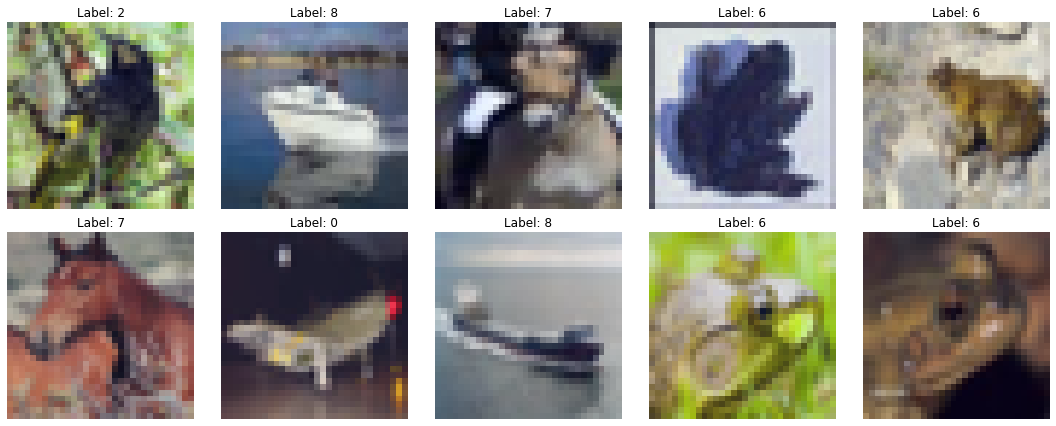

In [8]:
#Load and Visialize ImageNet dataloader
batch_size = 800
img_size = 224

# Load data for training
train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                                                      (0.24703233, 0.24348505, 0.26158768))
                             ])), shuffle=True, batch_size=batch_size)

# Load data for testing
test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('data', train=False, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                                                      (0.24703233, 0.24348505, 0.26158768))
                             ])), shuffle=True, batch_size=batch_size)

dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get the first 10 images and labels from the batch
images = images[:10]
labels = labels[:10]

# Conver to cpu and numpy
images = images.cpu().numpy()
images = images.transpose(0, 2, 3, 1)

images = (images - images.min()) / (images.max() - images.min())

# Compose the 10 images into a single plot
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# Display Un-pruned evaluation results
model_AlexNet.load_state_dict(torch.load('src/AlexNet/best_model.pth'))
test_loss, accuracy = evaluate(model_AlexNet, test_loader, device, nn.CrossEntropyLoss())
print(f'Original model, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

Original model, Test Loss: 2.3362, Accuracy: 0.7078


## 2.2 Pruning

In [11]:
# Apply ADMM pruning method to AlexNet
model2 = AlexNet()
percent = [0.8, 0.92, 0.93, 0.94, 0.95, 0.99, 0.99, 0.93]
model2.load_state_dict(torch.load('best_model_AlexNet.pth'))
pruned_model, mask = admm_pruning(model2, train_loader, percent)
test_loss, accuracy = evaluate(pruned_model, test_loader, device, criterion = nn.CrossEntropyLoss())
print(f'Pruned model, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch 1/10
normalized norm of (weight - projection)
(features.0.weight): 0.6789
(features.3.weight): 0.7027
(features.6.weight): 0.6619
(features.8.weight): 0.7247
(features.10.weight): 0.7841
(classifier.1.weight): 0.9215
(classifier.4.weight): 0.8836
(classifier.6.weight): 0.4313
Test Loss: 4.1955, Accuracy: 0.1000
Epoch 2/10
normalized norm of (weight - projection)
(features.0.weight): 0.2342
(features.3.weight): 0.2377
(features.6.weight): 0.3289
(features.8.weight): 0.3159
(features.10.weight): 0.4033
(classifier.1.weight): 0.7504
(classifier.4.weight): 0.8065
(classifier.6.weight): 0.1707
Test Loss: 3.5642, Accuracy: 0.1000
Epoch 3/10
normalized norm of (weight - projection)
(features.0.weight): 0.3343
(features.3.weight): 0.2494
(features.6.weight): 0.2414
(features.8.weight): 0.2455
(features.10.weight): 0.2824
(classifier.1.weight): 0.5080
(classifier.4.weight): 0.4663
(classifier.6.weight): 0.1121
Test Loss: 3.3132, Accuracy: 0.1044
Epoch 4/10
normalized norm of (weight - pro

Number of nonzero parameters in original model: 23272266
Number of nonzero parameters in pruned model: 360159
Percentage of weights pruned: 98.45%


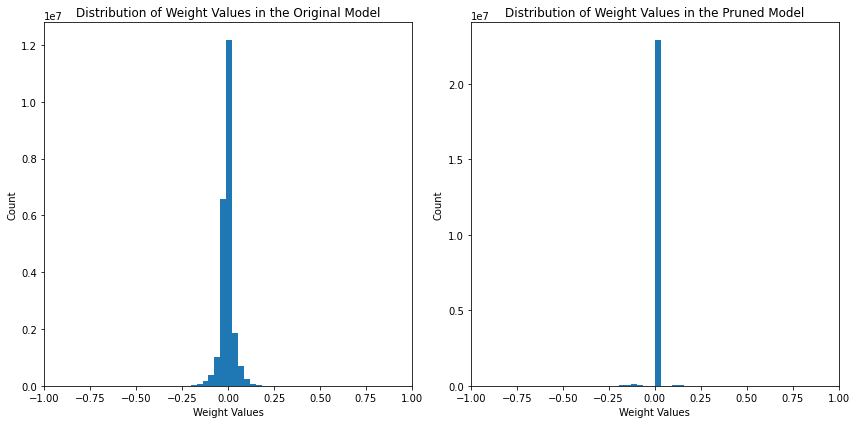

In [13]:
# Visualize model parameter changes and model size changes of AlexNet
from SimplePruning_Toolbox.utils import count_nonzero_params
print(f'Number of nonzero parameters in original model: {count_nonzero_params(model_AlexNet)}')
print(f'Number of nonzero parameters in pruned model: {count_nonzero_params(pruned_model)}')

# Plot the distribution of weights in the original and pruned models
weights_leorignal = []
weights_lepruned = []
for param in model_AlexNet.parameters():
    weights_leorignal += list(param.cpu().detach().numpy().flatten())
for param in pruned_model.parameters():
    weights_lepruned += list(param.cpu().detach().numpy().flatten())

# Show the percentage of weights that are pruned
print(f'Percentage of weights pruned: {(1 - count_nonzero_params(pruned_model) / count_nonzero_params(model_AlexNet)) * 100:.2f}%')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(weights_leorignal, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Original Model')
plt.xlim([-1, 1])

plt.subplot(1, 2, 2)  
plt.hist(weights_lepruned, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Pruned Model')
plt.xlim([-1, 1])

plt.tight_layout()
plt.show()

In [14]:
#Retrain the model of AlexNet
fine_tune_epochs = 10
optimizer = optim.Adam(pruned_model.parameters(), lr=1e-3)
for epoch in range(fine_tune_epochs):
    train(pruned_model, train_loader, device, optimizer=optimizer, criterion = nn.CrossEntropyLoss(), mask = mask)
    test_loss, accuracy = evaluate(pruned_model, test_loader, device, criterion = nn.CrossEntropyLoss())
    print(f'Epoch: {epoch + 1}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

# Save the pruned model
torch.save(pruned_model.state_dict(), 'pruned_model_AlexNet.pth')

Epoch: 1, Test Loss: 1.4374, Accuracy: 0.5241
Epoch: 2, Test Loss: 1.3424, Accuracy: 0.5564
Epoch: 3, Test Loss: 1.2949, Accuracy: 0.5751
Epoch: 4, Test Loss: 1.2554, Accuracy: 0.5838
Epoch: 5, Test Loss: 1.2031, Accuracy: 0.5976
Epoch: 6, Test Loss: 1.1846, Accuracy: 0.6043
Epoch: 7, Test Loss: 1.1535, Accuracy: 0.6100
Epoch: 8, Test Loss: 1.1379, Accuracy: 0.6147
Epoch: 9, Test Loss: 1.1098, Accuracy: 0.6227
Epoch: 10, Test Loss: 1.0995, Accuracy: 0.6263


Percentage of weights pruned: 99.97%


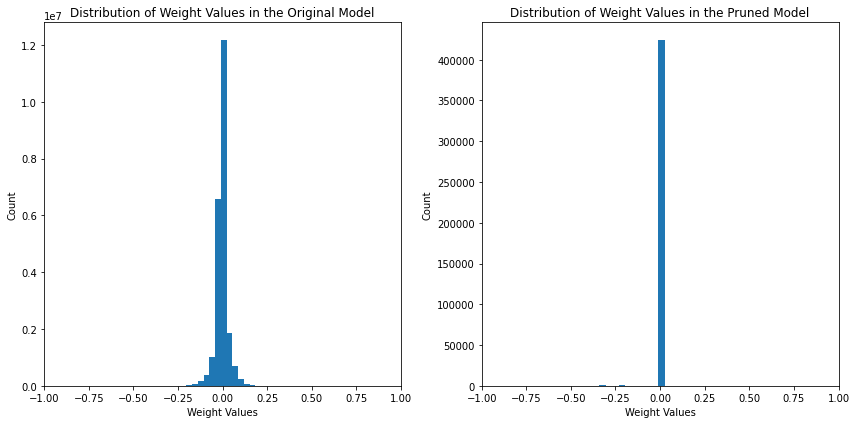

In [22]:
# Display the pruned results after fine-tuning
weights_leorignal = []
weights_lepruned = []
for param in model_AlexNet.parameters():
    weights_leorignal += list(param.cpu().detach().numpy().flatten())
for param in pruned_model.parameters():
    weights_lepruned += list(param.cpu().detach().numpy().flatten())

# Show the percentage of weights that are pruned
print(f'Percentage of weights pruned: {(1 - count_nonzero_params(pruned_model) / count_nonzero_params(model_AlexNet)) * 100:.2f}%')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(weights_leorignal, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Original Model')
plt.xlim([-1, 1])

plt.subplot(1, 2, 2)
plt.hist(weights_lepruned, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Pruned Model')
plt.xlim([-1, 1])

plt.tight_layout()
plt.show()


Comparison of origianl and pruned AlexNet
|  | Pretrained Model | Pruned Model | Retrained Model | Pruning Ratio |
|---------|---------|---------|---------|---------|
| Size |23272266  | 360159 | 360159 | 99.97% | 
| Accuracy | 0.7078 | 0.4389 | 0.6263 | - | 


# Part 3 - LeNet

![Lenet](images/lenet_5.png)

## 3.1 Define the Network

In [23]:
# Define LeNet-5 Network
model_LeNet = LeNet5()

# Summary of LeNet-5
summary(model_LeNet, (1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 20, 24, 24]          520
├─Conv2d: 1-2                            [-1, 50, 8, 8]            25,050
├─Linear: 1-3                            [-1, 500]                 400,500
├─Dropout: 1-4                           [-1, 500]                 --
├─Linear: 1-5                            [-1, 10]                  5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
Total mult-adds (M): 2.29
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.64
Estimated Total Size (MB): 1.76


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 20, 24, 24]          520
├─Conv2d: 1-2                            [-1, 50, 8, 8]            25,050
├─Linear: 1-3                            [-1, 500]                 400,500
├─Dropout: 1-4                           [-1, 500]                 --
├─Linear: 1-5                            [-1, 10]                  5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
Total mult-adds (M): 2.29
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.64
Estimated Total Size (MB): 1.76

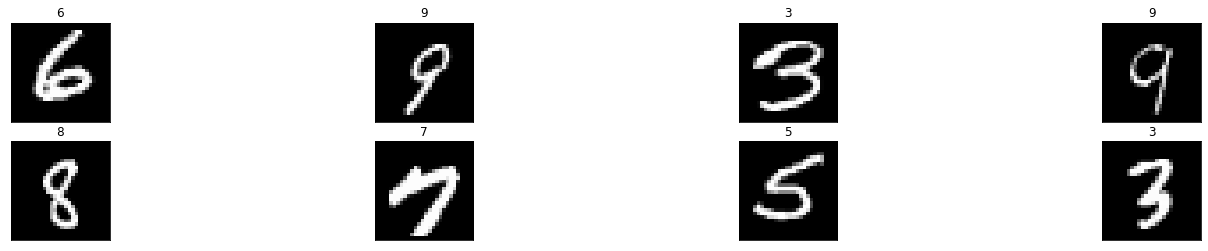

In [16]:
# Load and Visialize MNIST dataloader
batch_size = 256

train_set = MNIST('./', download=True,
        transform=transforms.Compose([
        transforms.ToTensor(),
]), train=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = MNIST('./', download=True,
        transform=transforms.Compose([
        transforms.ToTensor(),
]), train=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# Plot the images
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))

plt.show()

Epoch 5 - Training loss: 0.0324
Epoch 10 - Training loss: 0.0143
Epoch 15 - Training loss: 0.0078
Epoch 20 - Training loss: 0.0066
Epoch 25 - Training loss: 0.0046
Epoch 30 - Training loss: 0.0044


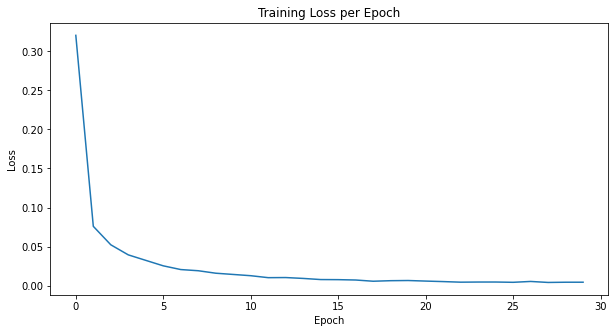

In [17]:
# Train and Load Pre-trained Best Model parameters
from SimplePruning_Toolbox.utils import train

   
epochs = 30
best_loss = float('inf')
losses = []

for epoch in range(epochs):
    avg_loss = train(model_LeNet, 
            train_loader, 
            device, 
            optimizer = optim.Adam(model_LeNet.parameters(), 
            lr=1e-3), 
            criterion = nn.CrossEntropyLoss(), mask=None)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1} - Training loss: {avg_loss:.4f}")
    losses.append(avg_loss)
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model_LeNet.state_dict(), 'best_model_LeNet.pth')
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.show()


In [18]:
# Display Un-pruned evaluation results
model_LeNet.load_state_dict(torch.load('best_model_LeNet.pth'))
test_loss, accuracy = evaluate(model_LeNet, test_loader, device, nn.CrossEntropyLoss())
print(f'Original model, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

Original model, Test Loss: 0.0299, Accuracy: 0.9940


## 3.2 Pruning

In [19]:
# Define ADMM Pruning method
percent = [0.8, 0.92, 0.991, 0.93]

In [20]:
# Apply ADMM pruning method to LeNet-5
model2 = LeNet5()
train_set = MNIST('./', download=True,
        transform=transforms.Compose([
        transforms.ToTensor(),
]), train=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = MNIST('./', download=True,
        transform=transforms.Compose([
        transforms.ToTensor(),
]), train=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
model2.load_state_dict(torch.load('best_model_LeNet.pth'))
pruned_model, mask = admm_pruning(model2, train_loader, percent)
test_loss, accuracy = evaluate(pruned_model, test_loader, device, criterion = nn.CrossEntropyLoss())
print(f'Pruned model, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 1/10
normalized norm of (weight - projection)
(conv1.weight): 0.6316
(conv2.weight): 0.7389
(fc1.weight): 0.9438
(fc2.weight): 0.7846
Test Loss: 2.6817, Accuracy: 0.0964
Epoch 2/10
normalized norm of (weight - projection)
(conv1.weight): 0.4189
(conv2.weight): 0.4621
(fc1.weight): 0.8658
(fc2.weight): 0.3895
Test Loss: 2.5661, Accuracy: 0.1267
Epoch 3/10
normalized norm of (weight - projection)
(conv1.weight): 0.4536
(conv2.weight): 0.4389
(fc1.weight): 0.6795
(fc2.weight): 0.3097
Test Loss: 2.4489, Accuracy: 0.1534
Epoch 4/10
normalized norm of (weight - projection)
(conv1.weight): 0.4394
(conv2.weight): 0.4119
(fc1.weight): 0.6521
(fc2.weight): 0.2973
Test Loss: 2.2810, Accuracy: 0.1787
Epoch 5/10
normalized norm of (weight - projection)
(conv1.weight): 0.3994
(conv2.weight): 0.3791
(fc1.weight): 0.6654
(fc2.weight): 0.2821
Test Loss: 2.0927, Accuracy: 0.2923
Epoch 6/10
normalized norm of (weight - projection)
(conv1.weight): 0.3751
(conv2.weight): 0.3604
(fc1.weight): 0.6790
(

Number of nonzero parameters in original model: 431080
Number of nonzero parameters in pruned model: 6630
Percentage of weights pruned: 98.46%


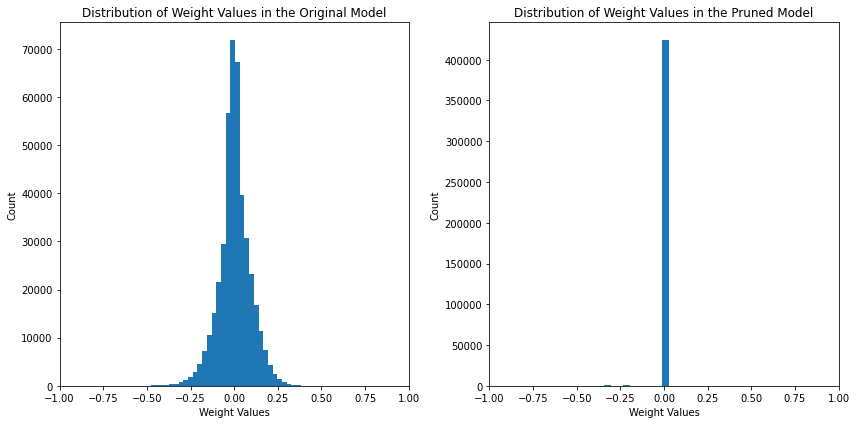

In [21]:
# Visualize model parameter changes and model size changes of LeNet-5
print(f'Number of nonzero parameters in original model: {count_nonzero_params(model_LeNet)}')
print(f'Number of nonzero parameters in pruned model: {count_nonzero_params(pruned_model)}')

# Show the percentage of weights that are pruned
print(f'Percentage of weights pruned: {(1 - count_nonzero_params(pruned_model) / count_nonzero_params(model_LeNet)) * 100:.2f}%')

# Plot the distribution of weights in the original and pruned models
weights_leorignal = []
weights_lepruned = []
for param in model_LeNet.parameters():
    weights_leorignal += list(param.cpu().detach().numpy().flatten())
for param in pruned_model.parameters():
    weights_lepruned += list(param.cpu().detach().numpy().flatten())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(weights_leorignal, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Original Model')
plt.xlim([-1, 1])

plt.subplot(1, 2, 2)  
plt.hist(weights_lepruned, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Pruned Model')
plt.xlim([-1, 1])

plt.tight_layout()
plt.show()


In [24]:
# Retrain the model of LeNet-5
fine_tune_epochs = 5
optimizer = optim.Adam(pruned_model.parameters(), lr=1e-3)
for epoch in range(fine_tune_epochs):
    train(pruned_model, train_loader, device, optimizer=optimizer, criterion = nn.CrossEntropyLoss(), mask = mask)
    test_loss, accuracy = evaluate(pruned_model, test_loader, device, criterion = nn.CrossEntropyLoss())
    print(f'Epoch: {epoch + 1}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch: 1, Test Loss: 0.6314, Accuracy: 0.8828
Epoch: 2, Test Loss: 0.5421, Accuracy: 0.9032
Epoch: 3, Test Loss: 0.4599, Accuracy: 0.9196
Epoch: 4, Test Loss: 0.3969, Accuracy: 0.9312
Epoch: 5, Test Loss: 0.3508, Accuracy: 0.9412


Percentage of weights pruned: 98.46%


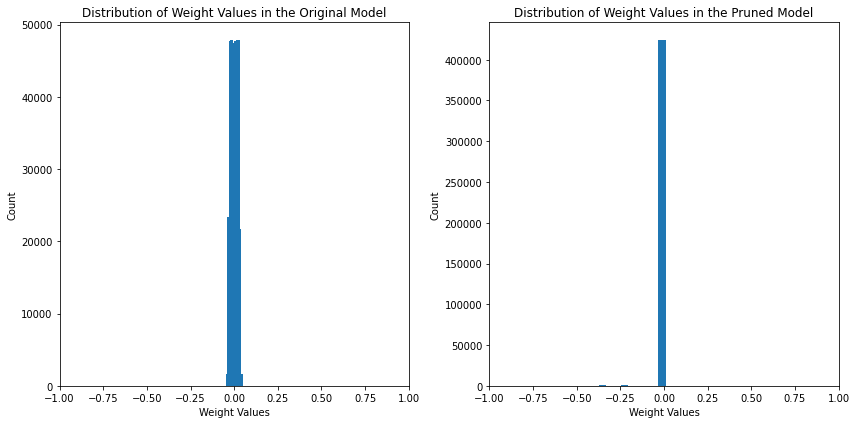

In [25]:
# Display the pruned results after fine-tuning
weights_leorignal = []
weights_lepruned = []
for param in model_LeNet.parameters():
    weights_leorignal += list(param.cpu().detach().numpy().flatten())
for param in pruned_model.parameters():
    weights_lepruned += list(param.cpu().detach().numpy().flatten())

# Show the percentage of weights that are pruned
print(f'Percentage of weights pruned: {(1 - count_nonzero_params(pruned_model) / count_nonzero_params(model_LeNet)) * 100:.2f}%')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(weights_leorignal, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Original Model')
plt.xlim([-1, 1])

plt.subplot(1, 2, 2)
plt.hist(weights_lepruned, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Pruned Model')
plt.xlim([-1, 1])

plt.tight_layout()
plt.show()


Comparison of origianl and pruned LeNet-5
|  | Pretrained Model | Pruned Model | Retrained Model | Pruning Ratio |
|---------|---------|---------|---------|---------|
| Size |61706  | 3310 | 3310 | 94.64% |
| Accuracy | 0.9914 | 0.8403 | 0.9093 | - |



# 4. VGG-8

## 4.1 Define the Network

![VGG-8](images/VGG_architecture.png)

In [27]:
# Define and load VGG-8 Network
model_VGG = VGG_8()
# Summary of VGG-8
summary(model_VGG, (3, 32, 32))
model_VGG.load_state_dict(torch.load('src/VGG_8/VGG_best_model.pth'))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 4, 4]           --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,792
|    └─ReLU: 2-2                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 64, 32, 32]          36,928
|    └─ReLU: 2-4                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-5                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-6                       [-1, 128, 16, 16]         73,856
|    └─ReLU: 2-7                         [-1, 128, 16, 16]         --
|    └─Conv2d: 2-8                       [-1, 128, 16, 16]         147,584
|    └─ReLU: 2-9                         [-1, 128, 16, 16]         --
|    └─MaxPool2d: 2-10                   [-1, 128, 8, 8]           --
|    └─Conv2d: 2-11                      [-1, 256, 8, 8]           295,168
|    └─ReLU: 2-12                        [-1, 256, 8, 8]        

<All keys matched successfully>

In [28]:
batch_size = 512

#Load data for training
train_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('data', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                                                      (0.24703233, 0.24348505, 0.26158768))
                             ])), shuffle=True, batch_size=batch_size)

#Load data for testing
test_loader = torch.utils.data.DataLoader(
            datasets.CIFAR10('data', train=False, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.49139968, 0.48215827, 0.44653124),
                                                      (0.24703233, 0.24348505, 0.26158768))
                             ])), shuffle=True, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


## 4.2 pruning

In [30]:
# Apply ADMM pruning method to AlexNet
model_VGG_2 = VGG_8()
percent = [0.85] * 9
model_VGG_2.load_state_dict(torch.load('src/VGG_8/VGG_best_model.pth'))
test_loss, accuracy = evaluate(model_VGG_2, test_loader, device, criterion = nn.CrossEntropyLoss())
print(f'Original model, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')
pruned_model, mask = admm_pruning(model_VGG_2, train_loader, percent)
test_loss, accuracy = evaluate(pruned_model, test_loader, device, criterion = nn.CrossEntropyLoss())
print(f'Pruned model, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

Original model, Test Loss: 1.0424, Accuracy: 0.8020
Epoch 1/10
normalized norm of (weight - projection)
(features.0.weight): 0.7567
(features.2.weight): 0.5802
(features.5.weight): 0.5881
(features.7.weight): 0.6085
(features.10.weight): 0.5964
(features.12.weight): 0.5293
(classifier.0.weight): 0.3715
(classifier.3.weight): 0.5203
(classifier.6.weight): 0.5261
Test Loss: 6.9457, Accuracy: 0.1001
Epoch 2/10
normalized norm of (weight - projection)
(features.0.weight): 0.3368
(features.2.weight): 0.3023
(features.5.weight): 0.2994
(features.7.weight): 0.2768
(features.10.weight): 0.2795
(features.12.weight): 0.3143
(classifier.0.weight): 0.3240
(classifier.3.weight): 0.3714
(classifier.6.weight): 0.2410
Test Loss: 2.8838, Accuracy: 0.1262
Epoch 3/10
normalized norm of (weight - projection)
(features.0.weight): 0.4717
(features.2.weight): 0.2877
(features.5.weight): 0.2654
(features.7.weight): 0.2929
(features.10.weight): 0.2788
(features.12.weight): 0.2534
(classifier.0.weight): 0.2161


In [31]:
# Retrain the model of VGG-8
fine_tune_epochs = 5
optimizer = optim.Adam(pruned_model.parameters(), lr=1e-3)
for epoch in range(fine_tune_epochs):
    train(pruned_model, train_loader, device, optimizer=optimizer, criterion = nn.CrossEntropyLoss(), mask=mask)
    test_loss, accuracy = evaluate(pruned_model, test_loader, device, criterion = nn.CrossEntropyLoss())
    print(f'Epoch: {epoch + 1}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch: 1, Test Loss: 0.7260, Accuracy: 0.7727
Epoch: 2, Test Loss: 0.7262, Accuracy: 0.7807
Epoch: 3, Test Loss: 0.7203, Accuracy: 0.7913
Epoch: 4, Test Loss: 0.7343, Accuracy: 0.7935
Epoch: 5, Test Loss: 0.7288, Accuracy: 0.7983


Number of nonzero parameters in original model: 6400586
Number of nonzero parameters in pruned model: 962603
Percentage of weights pruned: 84.96%


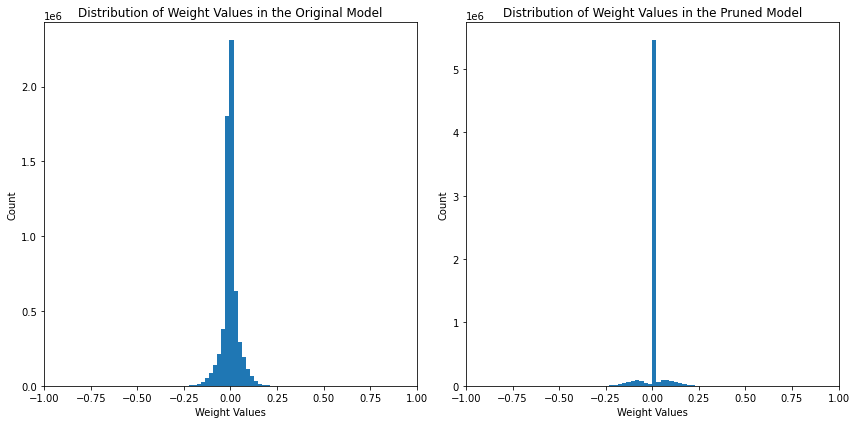

In [32]:
# Visualize model parameter changes and model size changes of VGG-8
print(f'Number of nonzero parameters in original model: {count_nonzero_params(model_VGG)}')
print(f'Number of nonzero parameters in pruned model: {count_nonzero_params(pruned_model)}')

# Show the percentage of weights that are pruned
print(f'Percentage of weights pruned: {(1 - count_nonzero_params(pruned_model) / count_nonzero_params(model_VGG)) * 100:.2f}%')

# Plot the distribution of weights in the original and pruned models
weights_leorignal = []
weights_lepruned = []
for param in model_VGG.parameters():
    weights_leorignal += list(param.cpu().detach().numpy().flatten())
for param in pruned_model.parameters():
    weights_lepruned += list(param.cpu().detach().numpy().flatten())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(weights_leorignal, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Original Model')
plt.xlim([-1, 1])

plt.subplot(1, 2, 2)  
plt.hist(weights_lepruned, bins=50)
plt.xlabel('Weight Values')
plt.ylabel('Count')
plt.title('Distribution of Weight Values in the Pruned Model')
plt.xlim([-1, 1])

plt.tight_layout()
plt.show()


|  | Pretrained Model | Pruned Model | Retrained Model | Pruning Ratio |
|---------|---------|---------|---------|---------|
| Size |6400586  | 962603 | 962603 | 84.96% |
| Accuracy | 0.8021 | 0.7728 | 0.8018 | - |
